# 3.2-Clustering and further filtering

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-10"

## Introduction

Clustering and filtering doublets

## Libraries

In [2]:
suppressMessages(suppressWarnings({
library(Seurat)
library(here)
library(glue)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [3]:
#dr_here(show_reason = TRUE)
source(here("SCGRES_99_100/sc_analysis/misc/paths.R"))
source(here("utils/bin.R"))

set.seed(0)

## Load data

In [4]:
seurat_obj <- readRDS(here(glue("{clust}/{robj_dir}/dimred_combined_object_T0_CD45pos.rds")))

### First clustering to localize doublets

In [5]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:30)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13097
Number of edges: 534620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9725
Number of communities: 9
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13097
Number of edges: 534620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9568
Number of communities: 13
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13097
Number of edges: 534620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9445
Number of communities: 15
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13097
Number of edges: 534620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9336
Number of communities: 17
Elapsed time: 1 seconds
Modularity Op

In [6]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

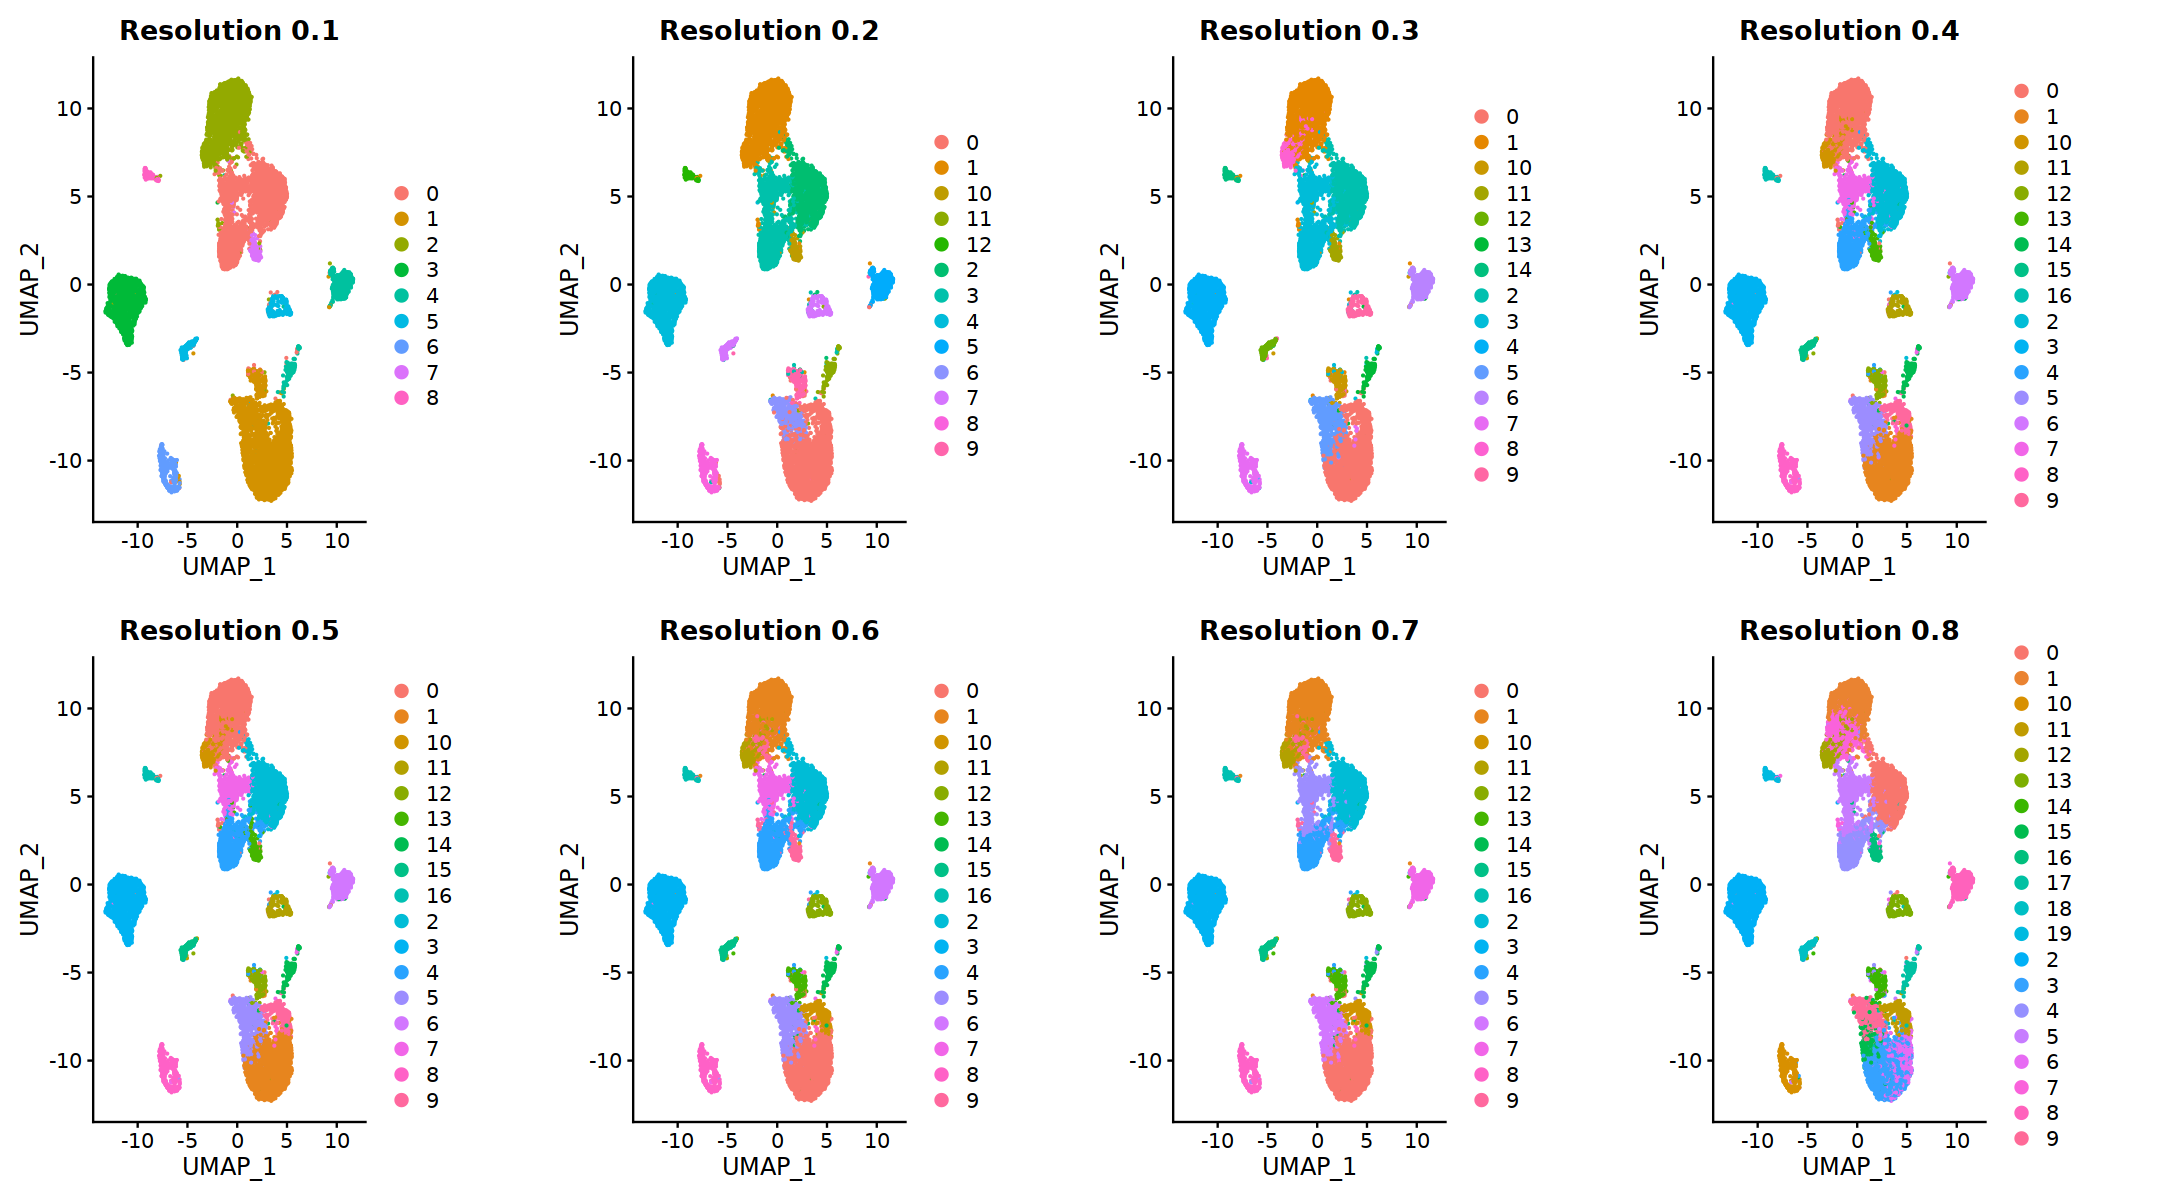

In [7]:
options(repr.plot.width = 18, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

In [8]:
reso = 0.3

In [9]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13097
Number of edges: 534620

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9445
Number of communities: 15
Elapsed time: 1 seconds


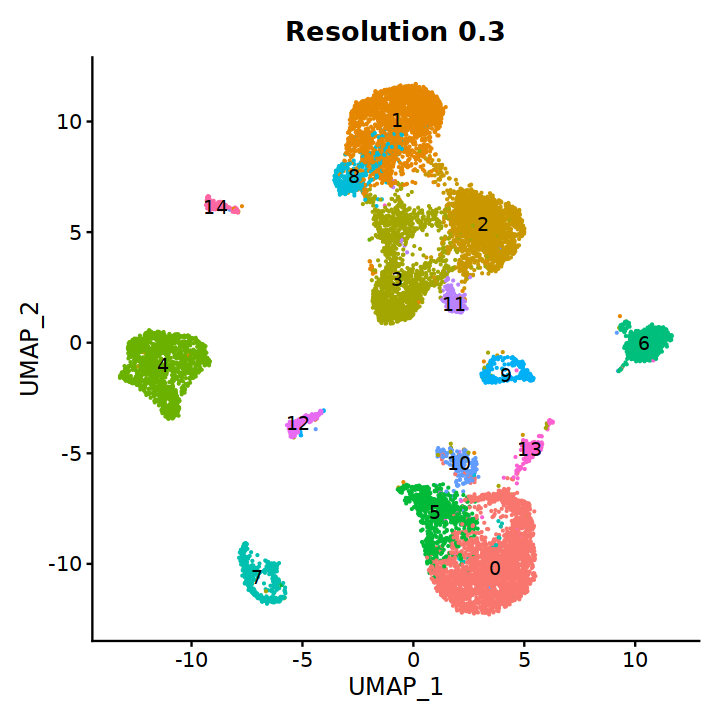

In [10]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

In [11]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



These looks like tumor cells

In [12]:
c <- 4

rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster
COL1A2      0.000000e+00 4.078664   0.990 0.125  0.000000e+00 4      
CNTNAP2    1.333296e-282 3.932989   0.832 0.017 4.142817e-278 4      
AC109466.1 1.476780e-295 3.896861   0.869 0.016 4.588651e-291 4      
COL3A1     3.741418e-287 3.581743   0.951 0.114 1.162533e-282 4      
MEG3        0.000000e+00 3.500194   0.946 0.032  0.000000e+00 4      
PCDH9      7.407640e-294 3.456380   0.900 0.052 2.301702e-289 4      
           gene      
COL1A2     COL1A2    
CNTNAP2    CNTNAP2   
AC109466.1 AC109466.1
COL3A1     COL3A1    
MEG3       MEG3      
PCDH9      PCDH9

These look like fibroblasts

In [13]:
c <- 7

rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene  
COL4A1 1.028069e-271 5.222350   0.971 0.048 3.194416e-267 7       COL4A1
PRKG1  5.314769e-251 4.798771   0.912 0.030 1.651405e-246 7       PRKG1 
COL4A2 1.219924e-277 4.622971   0.954 0.023 3.790549e-273 7       COL4A2
CALD1  1.059453e-255 4.377055   0.968 0.101 3.291931e-251 7       CALD1 
FN11   1.187559e-229 4.257020   0.903 0.068 3.689984e-225 7       FN1   
SPARC1 8.709833e-223 4.206133   0.943 0.147 2.706319e-218 7       SPARC

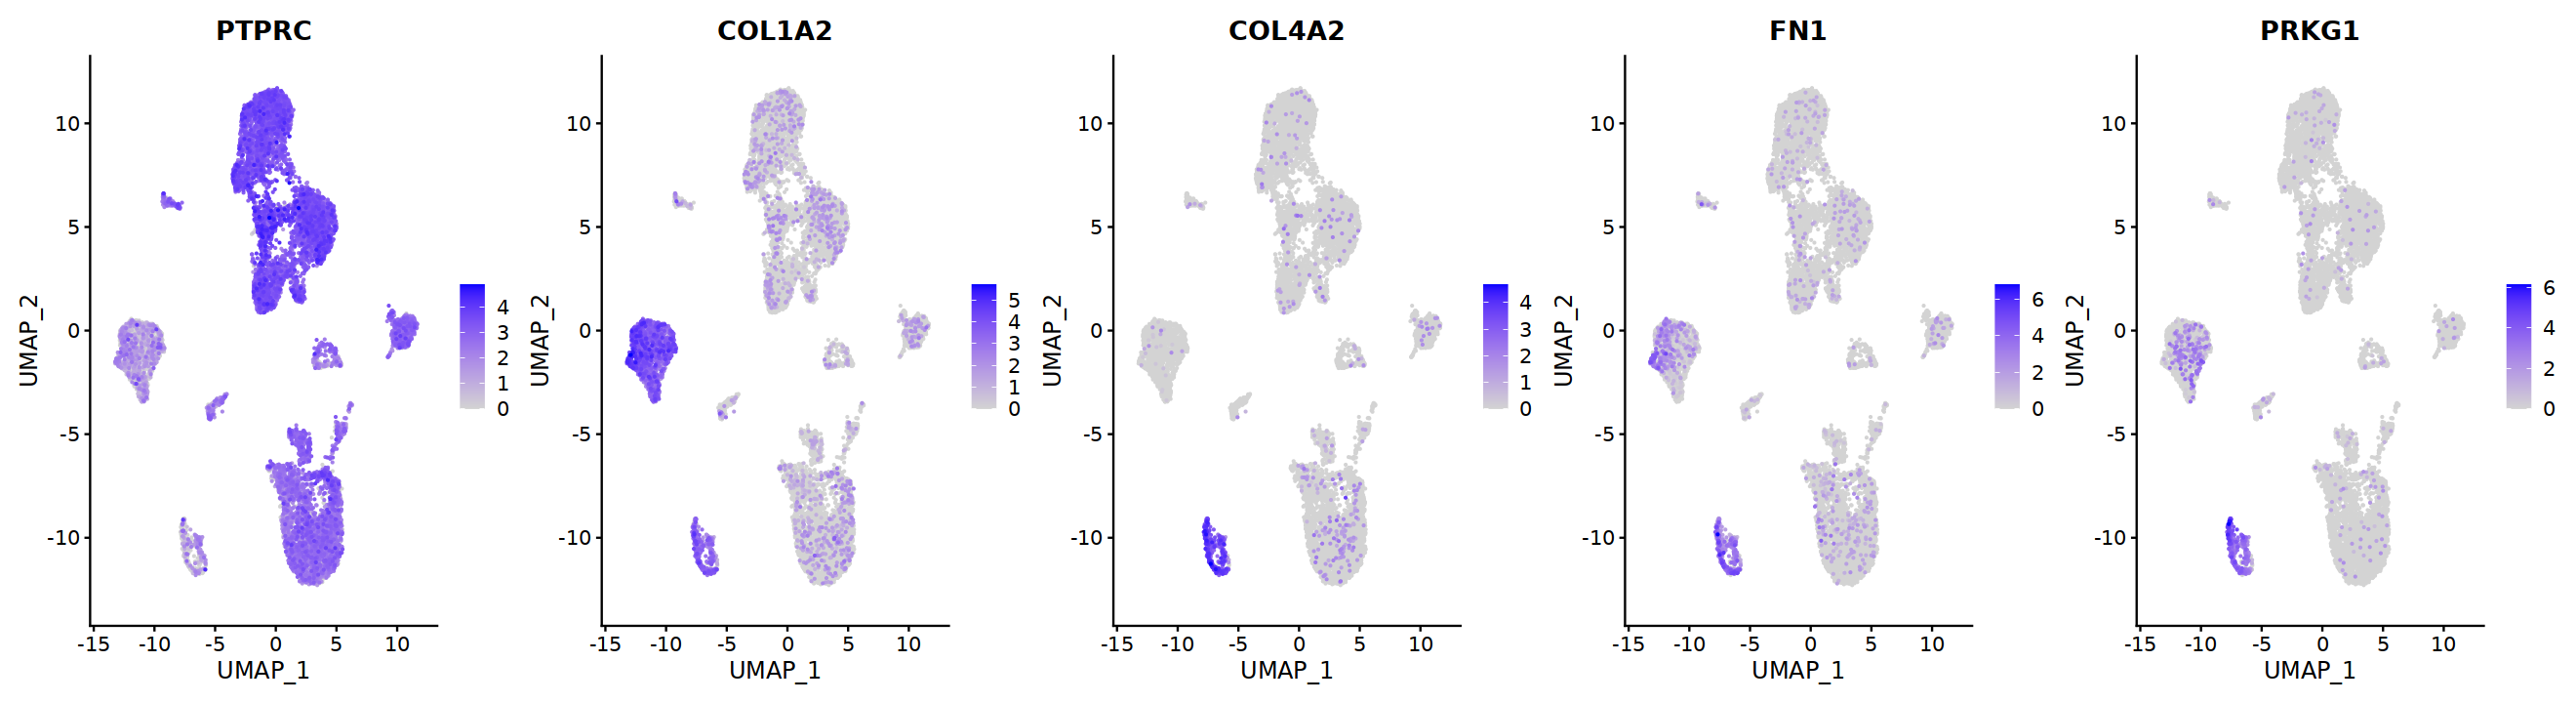

In [14]:
options(repr.plot.width = 22, repr.plot.height = 6, warn=-1,verbose = FALSE)

var = c("PTPRC", "COL1A2", "COL4A2", "FN1", "PRKG1")
# show plots
FeaturePlot(seurat_obj, reduction = "umap", feature=var, order = TRUE, ncol=5)

These are doublets (positive for CD3, CD14 and CD68)

In [15]:
c <- 10

rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=30)

p_val        avg_log2FC pct.1 pct.2 p_val_adj    cluster gene    
S100A81   6.637410e-70 1.0730419  0.912 0.262 2.062376e-65 10      S100A8  
S100A91   2.521470e-62 1.0332876  0.929 0.318 7.834711e-58 10      S100A9  
S100A121  2.871753e-37 0.8265497  0.517 0.128 8.923110e-33 10      S100A12 
VCAN2     2.138187e-53 0.8130587  0.971 0.310 6.643775e-49 10      VCAN    
S100A43   2.047534e-31 0.7999650  0.975 0.646 6.362098e-27 10      S100A4  
LYZ2      3.465607e-54 0.7685202  0.871 0.271 1.076833e-49 10      LYZ     
FCN12     8.336563e-54 0.7549205  0.854 0.231 2.590337e-49 10      FCN1    
IL1R21    3.191269e-23 0.7375457  0.258 0.058 9.915911e-19 10      IL1R2   
SLC11A12  8.708806e-46 0.7262402  0.796 0.224 2.706000e-41 10      SLC11A1 
THBS13    1.422358e-23 0.6837156  0.558 0.204 4.419550e-19 10      THBS1   
SH3BGRL32 2.747267e-30 0.6835035  0.983 0.728 8.536308e-26 10      SH3BGRL3
S100A63   7.796289e-35 0.6815954  0.988 0.594 2.422463e-30 10      S100A6  
DUSP12    1.688044e-27 0.6663901  0.883 0.474 5.245091e-23 10      DUSP1   
RHOB2     1.738375e-26 0.6391189  0.642 0.248 5.401479e-22 10      RHOB    
TNFRSF1B2 8.055194e-27 0.6372491  0.775 0.327 2.502910e-22 10      TNFRSF1B
BATF2     6.570088e-23 0.6320734  0.562 0.208 2.041458e-18 10      BATF    
SERPINA12 1.862194e-39 0.6306774  0.721 0.207 5.786209e-35 10      SERPINA1
RAB312    2.629211e-25 0.6304557  0.646 0.243 8.169484e-21 10      RAB31   
FOS1      4.724631e-27 0.6254327  0.971 0.661 1.468037e-22 10      FOS     
IER53     7.413815e-19 0.6213288  0.496 0.205 2.303621e-14 10      IER5    
SAT12     3.611802e-30 0.6182729  0.983 0.714 1.122259e-25 10      SAT1    
COTL12    1.029160e-25 0.6171031  0.804 0.366 3.197805e-21 10      COTL1   
LST12     3.164275e-38 0.6122397  0.700 0.209 9.832034e-34 10      LST1    
ACSL12    3.712928e-43 0.6059171  0.838 0.263 1.153681e-38 10      ACSL1   
DNAJA41   2.077576e-31 0.6052366  0.604 0.215 6.455445e-27 10      DNAJA4  
S100A102  6.869373e-29 0.6042135  0.842 0.370 2.134452e-24 10      S100A10 
IL323     1.885655e-28 0.5999154  0.917 0.462 5.859108e-24 10      IL32    
PLAUR2    5.082047e-31 0.5943312  0.600 0.192 1.579094e-26 10      PLAUR   
LILRA52   3.061551e-32 0.5941250  0.483 0.129 9.512851e-28 10      LILRA5  
NAMPT2    1.269971e-22 0.5932768  0.808 0.443 3.946053e-18 10      NAMPT

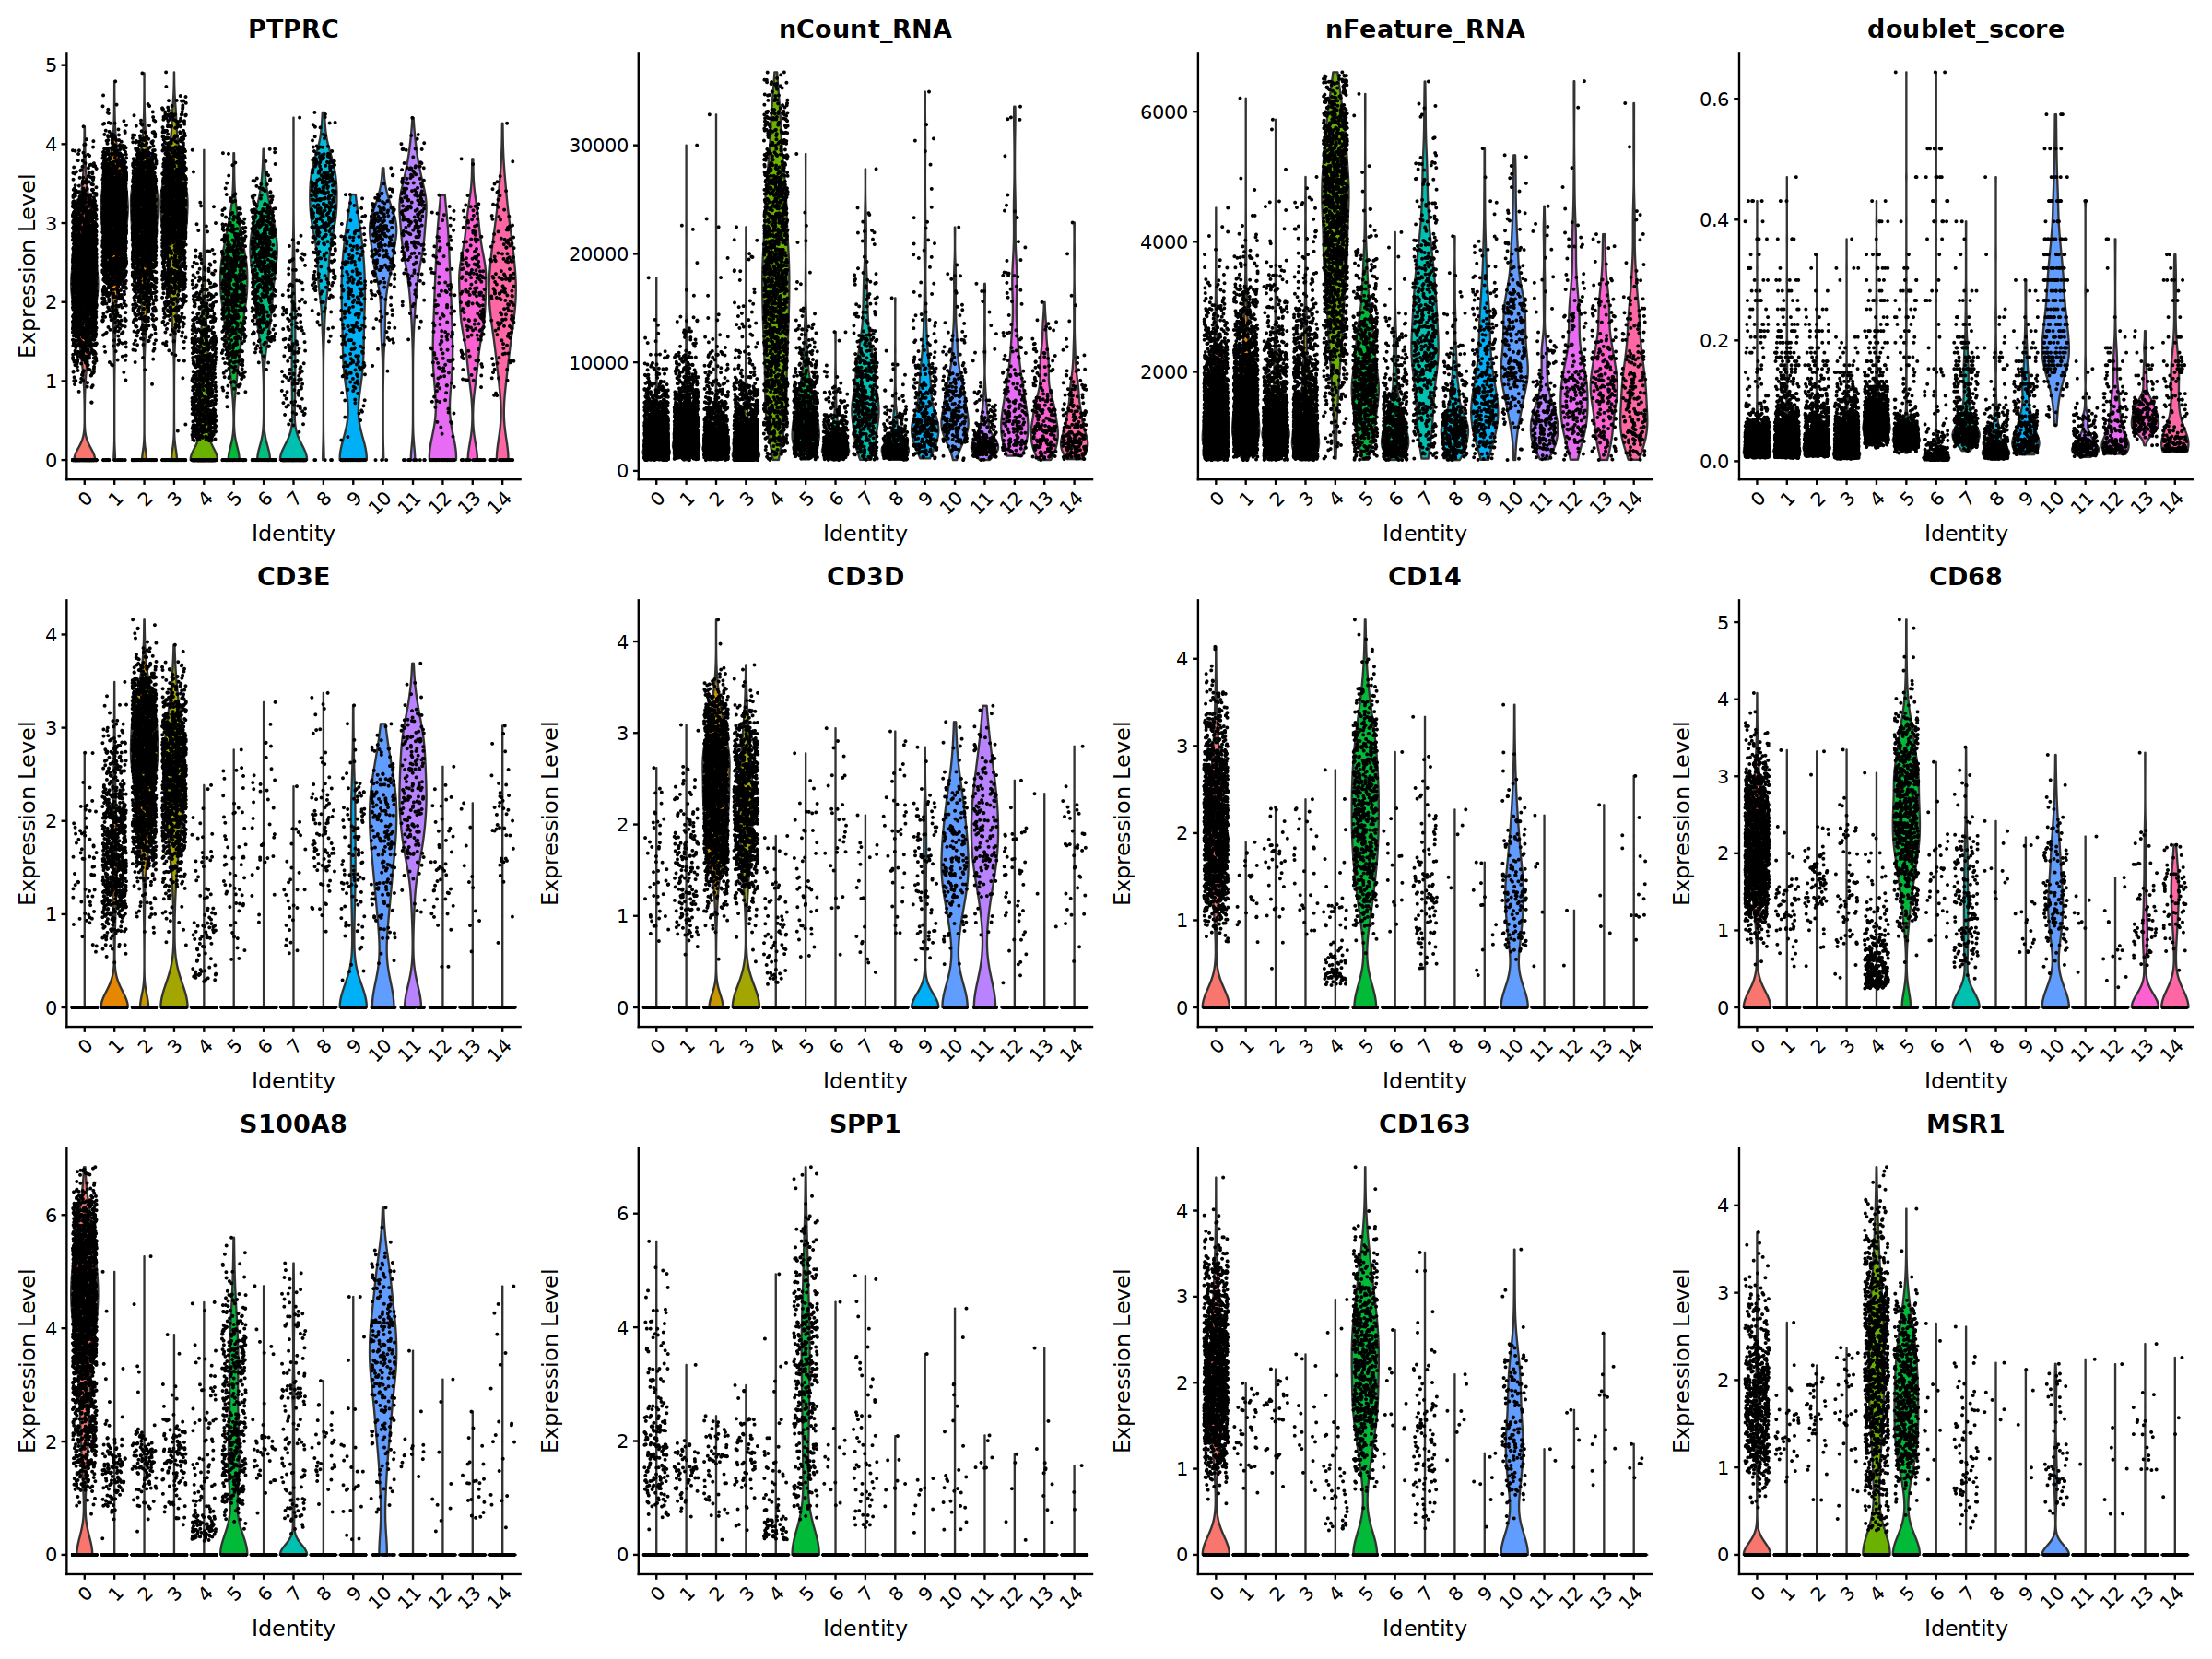

In [16]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=c("PTPRC","nCount_RNA", "nFeature_RNA",
                              "doublet_score",
                              "CD3E", "CD3D","CD14", "CD68", 
                              "S100A8", "SPP1", "CD163", "MSR1"), ncol=4)

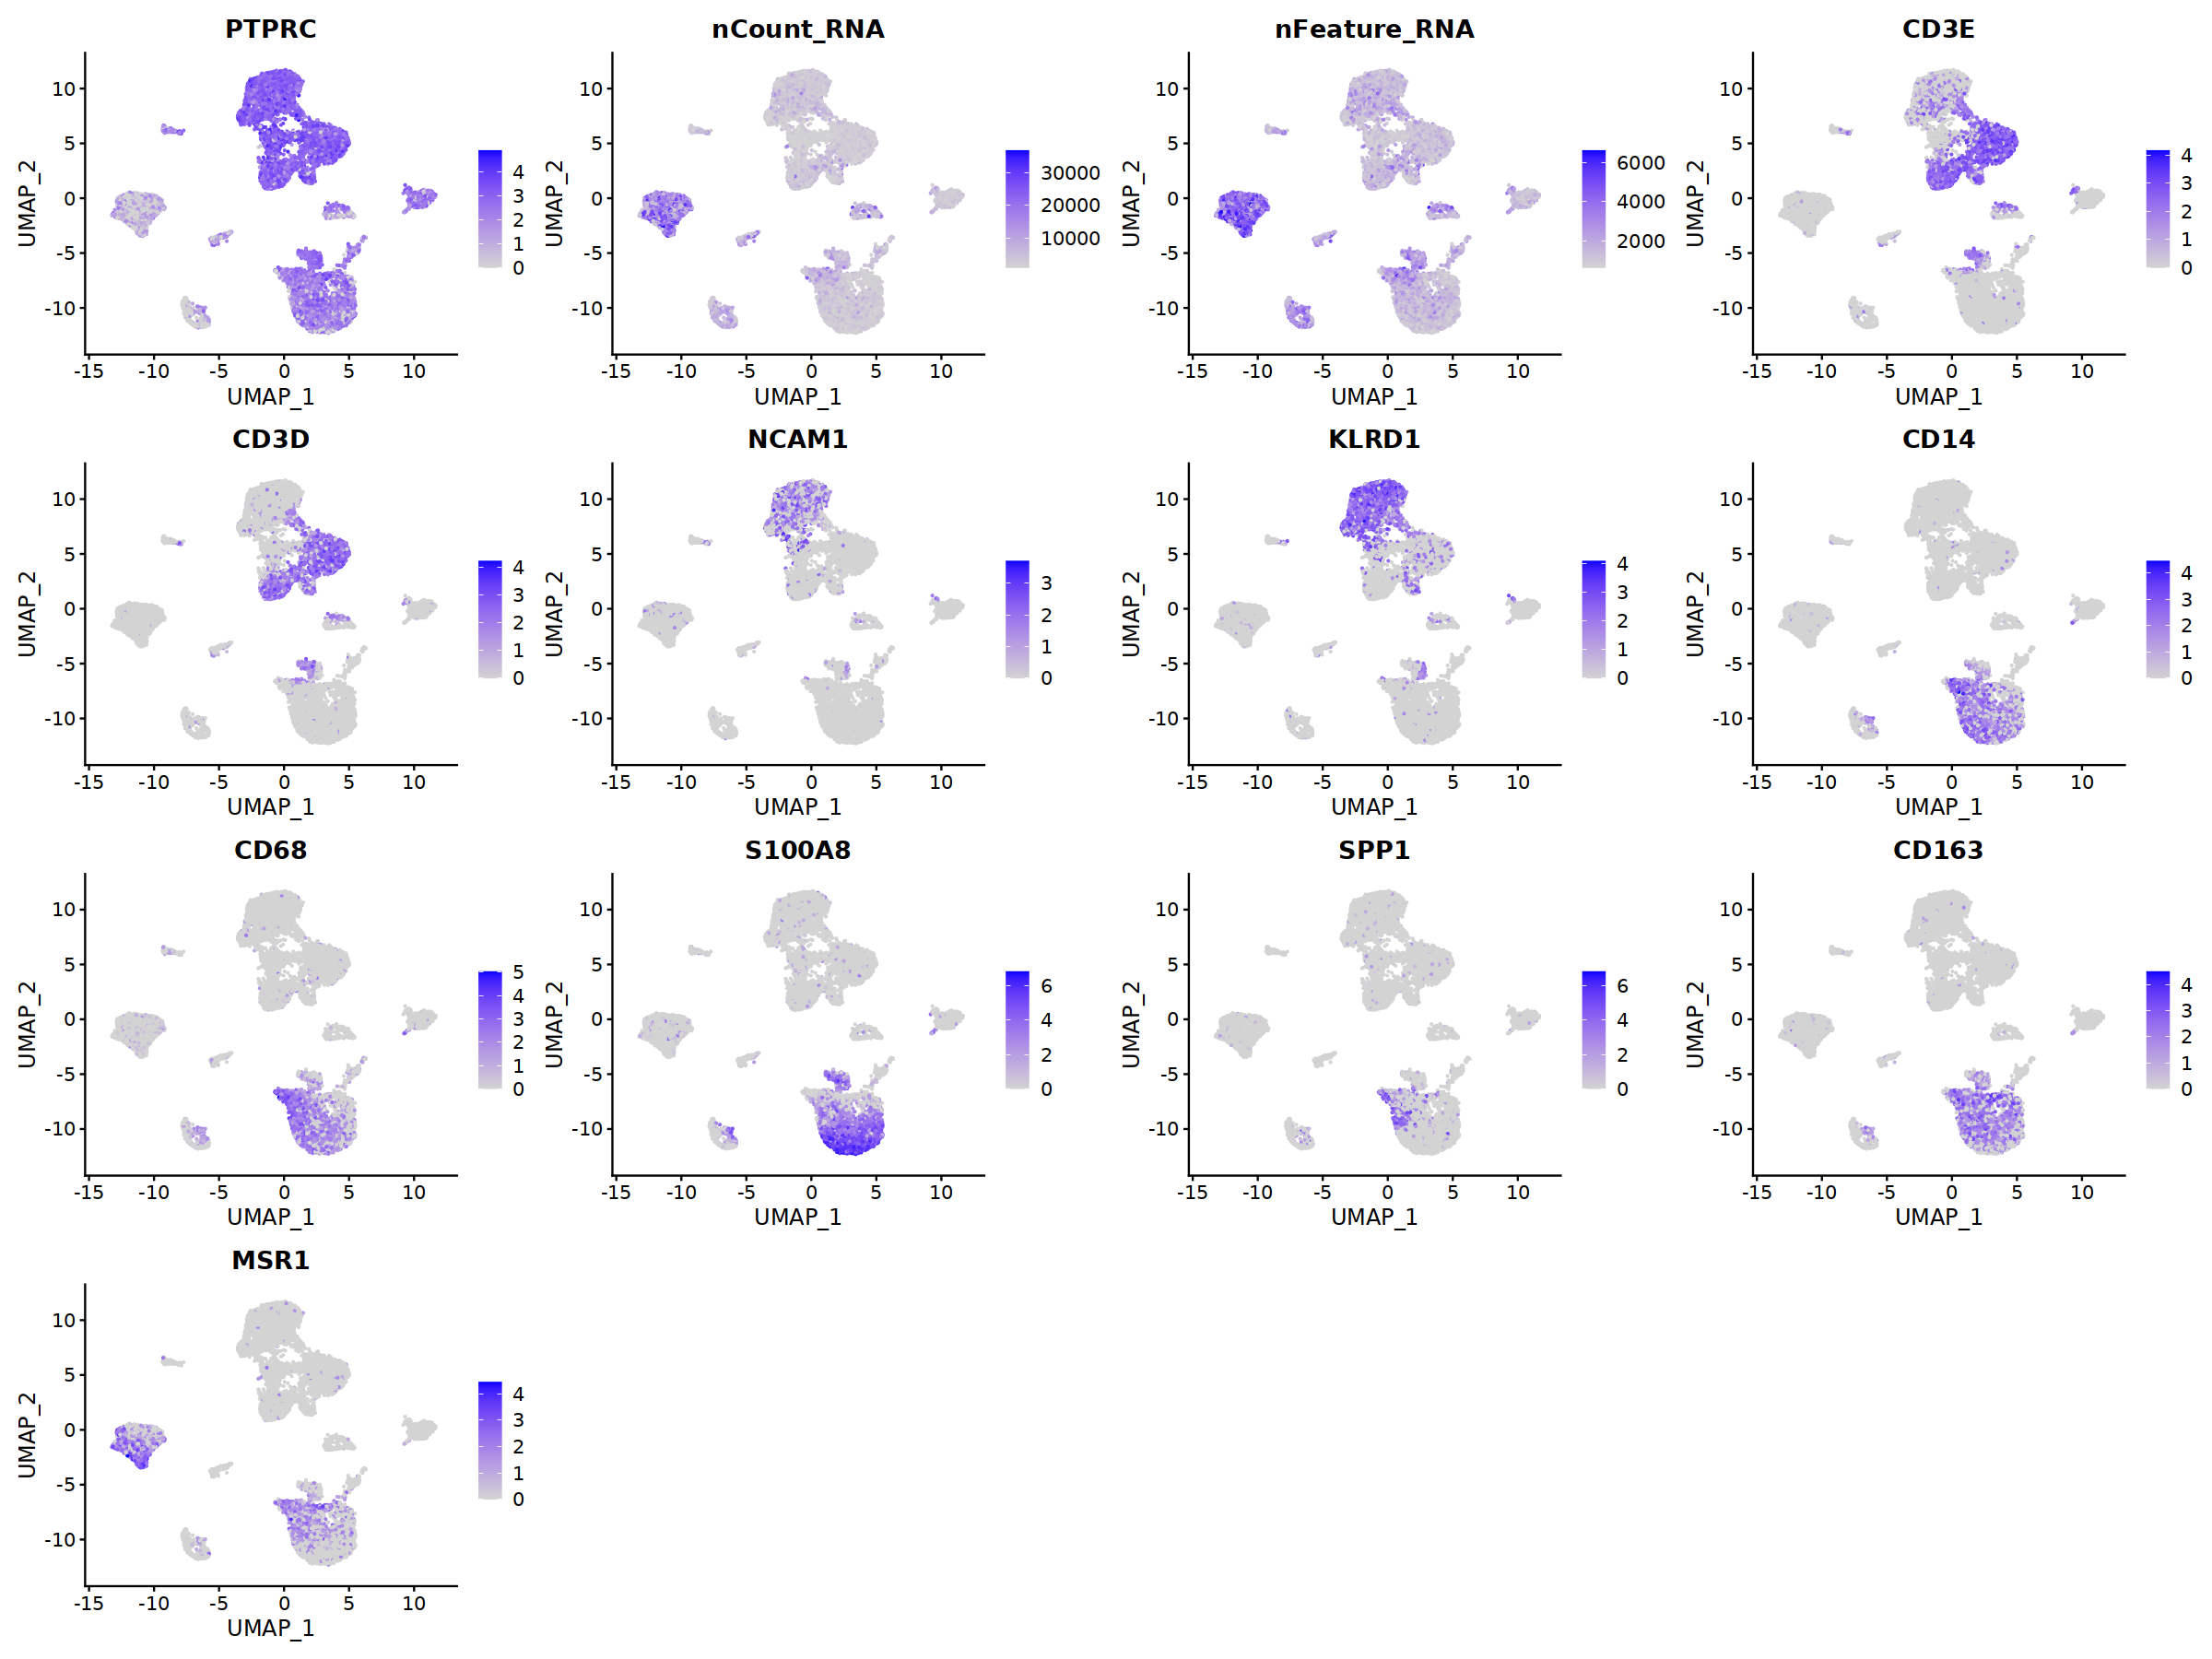

In [17]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, ncol=4,
            feature=c("PTPRC","nCount_RNA", "nFeature_RNA", 
                       "CD3E", "CD3D","NCAM1","KLRD1","CD14", "CD68", 
                       "S100A8", "SPP1", "CD163", "MSR1"))

### Remove cells 

Remove cells that have low CD45 expression that actually look like tumor or fibros or doublets

In [18]:
seurat_obj <- subset(x = seurat_obj, idents=c(4,7,10), invert=TRUE)

In [19]:
print(table(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) == 0))
  
keep_genes <- data.frame(rowSums(as.matrix(seurat_obj[['RNA']]@counts)) != 0)
colnames(keep_genes) <- "logical"
keep_genes <- subset(keep_genes, logical==TRUE)
seurat_obj[['RNA']]@counts <- seurat_obj[['RNA']]@counts[rownames(keep_genes), ]
seurat_obj[['RNA']]@data <- seurat_obj[['RNA']]@data[rownames(keep_genes), ]
seurat_obj


FALSE  TRUE 
27783  3289 


An object of class Seurat 
27783 features across 10980 samples within 1 assay 
Active assay: RNA (27783 features, 476 variable features)
 2 dimensional reductions calculated: pca, umap

## Re-do embedding and clustering

In [20]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [21]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 27783 10980 
metadata(0):
assays(2): counts logcounts
rownames(27783): AL627309.1 AL627309.5 ... AC007325.1 AC007325.4
rowData names(0):
colnames(10980): AAACCTGAGAAGGTGA-1 AAACCTGCAAATACAG-1 ...
  TTTGTCATCGTAGGAG-1 TTTGTCATCGTTGCCT-1
colData names(18): orig.ident nCount_RNA ... seurat_clusters ident
reducedDimNames(2): PCA UMAP
mainExpName: RNA
altExpNames(0):

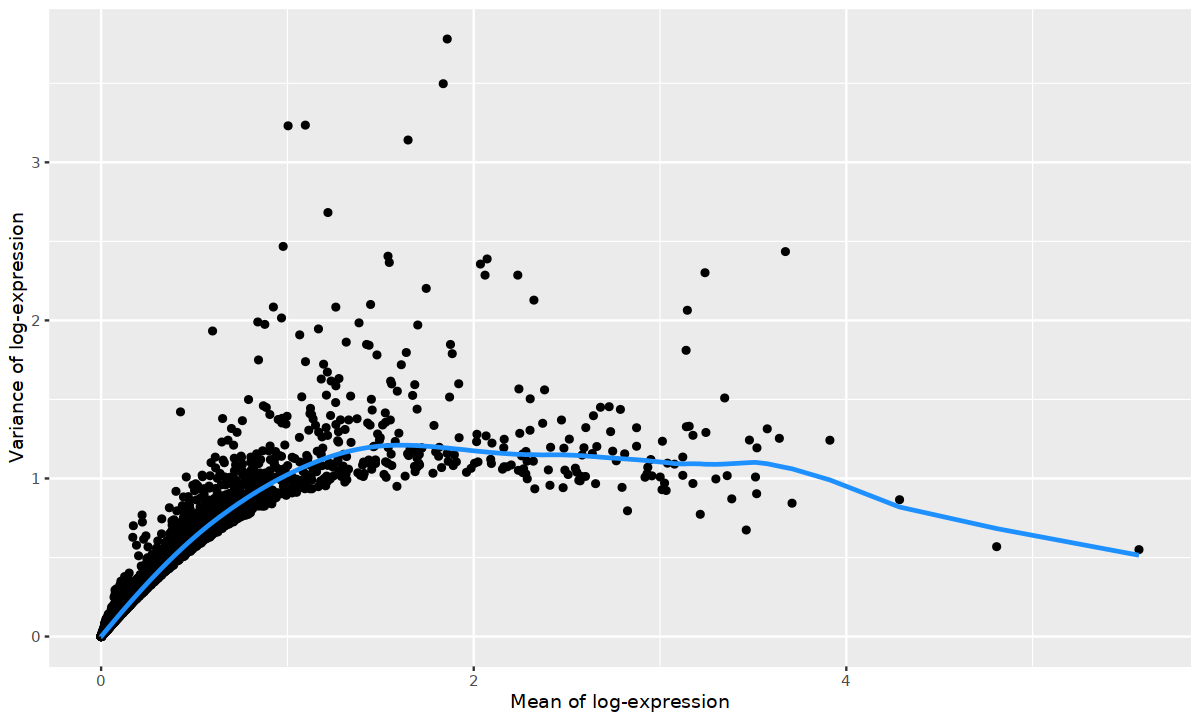

In [22]:
options(repr.plot.width = 10, repr.plot.height = 6, warn=-1,verbose = FALSE)
gene_var <- modelGeneVar(sce)
gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")

In [23]:
gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

mean      total    tech      bio       p.value      FDR         
CCL5   1.8577581 3.780215 1.1927451 2.5874699 3.830514e-53 3.547439e-49
NKG7   1.8362955 3.497492 1.1948830 2.3026093 2.260842e-42 4.831768e-39
S100A9 1.0961331 3.235447 1.0770772 2.1583697 1.186389e-45 4.708779e-42
S100A8 1.0035403 3.230966 1.0260491 2.2049165 3.458747e-52 2.402359e-48
IL32   1.6474799 3.141192 1.2100875 1.9311045 1.092985e-29 9.380095e-27
CCL4   1.2174203 2.682379 1.1332009 1.5491784 2.664330e-22 1.276260e-19
VCAN   0.9771425 2.467983 1.0102899 1.4576927 1.268003e-24 7.495519e-22
HSPA1A 3.6731193 2.435313 1.0693302 1.3659829 1.036407e-19 4.234485e-17
CD69   1.5398260 2.406190 1.2081733 1.1980170 1.340678e-12 2.738828e-10
FOS    2.0718951 2.388805 1.1668186 1.2219861 7.552388e-14 1.748567e-11
TYROBP 1.5468104 2.366490 1.2086610 1.1578289 7.084824e-12 1.348203e-09
JUN    2.0360725 2.356284 1.1709308 1.1853531 4.678652e-13 9.962933e-11
HSPA1B 3.2414468 2.301669 1.0899735 1.2116960 2.245711e-15 5.999286e-13
NEAT1  2.2365561 2.286396 1.1521150 1.1342811 1.911104e-12 3.847550e-10
SAT1   2.0607102 2.286316 1.1680852 1.1182311 7.303031e-12 1.380273e-09
IFITM1 1.7450005 2.202439 1.2042296 0.9982092 2.514926e-09 3.797401e-07
DNAJB1 2.3231091 2.128233 1.1505572 0.9776762 1.029797e-09 1.598372e-07
S100A6 1.4463695 2.100655 1.1979029 0.9027521 5.331553e-08 7.053645e-06
CCL3   0.9245915 2.084475 0.9773355 1.1071394 6.775279e-16 1.940594e-13
GZMA   1.2596936 2.084049 1.1493983 0.9346512 4.873461e-09 7.088972e-07

In [24]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 627

In [25]:
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]
length(hvgs)

[1] 545

In [26]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  CST7, CCL5, NKG7, GZMA, CD69, CTSW, IFITM1, IL32, GZMK, PRF1 
	   CCL4, CD3E, GZMB, RGS1, KLRD1, KLRB1, CD3D, CCL3, CCL4L2, IFNG 
	   KLRC1, XCL1, XCL2, GNLY, LTB, CTLA4, VCAM1, IL7R, STMN1, MKI67 
Negative:  IFI30, VCAN, LYZ, S100A9, FCN1, AIF1, SERPINA1, S100A8, SLC11A1, ACSL1 
	   PLXDC2, GLUL, RNF144B, CD14, CD68, CTSB, FTH1, PSAP, CD163, S100A11 
	   SLC8A1, TIMP1, S100A6, ZEB2, PLAUR, NEAT1, SOD2, SAT1, THBS1, FTL 
PC_ 2 
Positive:  NKG7, CCL5, CTSW, GZMA, CST7, IFITM1, PRF1, FCER1G, TYROBP, CCL3 
	   IFITM3, CCL4, KLRD1, GZMK, KLRB1, GZMB, IL32, KLRC1, CCL4L2, S100A4 
	   S100A11, XCL1, XCL2, IFNG, CD3E, RGS1, GNLY, ZFP36, FTL, S100A6 
Negative:  MS4A1, FCRL1, CD79A, BANK1, LINC00926, TCL1A, AFF3, NIBAN3, EBF1, VPREB3 
	   BACH2, IGHM, IGHD, JCHAIN, IGKC, AL589693.1, HLA-DRA, IGLC1, IGLC2, SOX5 
	   IGHV3-23, IGHG3, IGHG1, CCSER1, IGLC3, HLA-DRB1, CD74, IGHG4, LTB, IGHGP 
PC_ 3 
Positive:  HPGDS, TPSD1, MS4A2, KIT, HDC, SLC24A

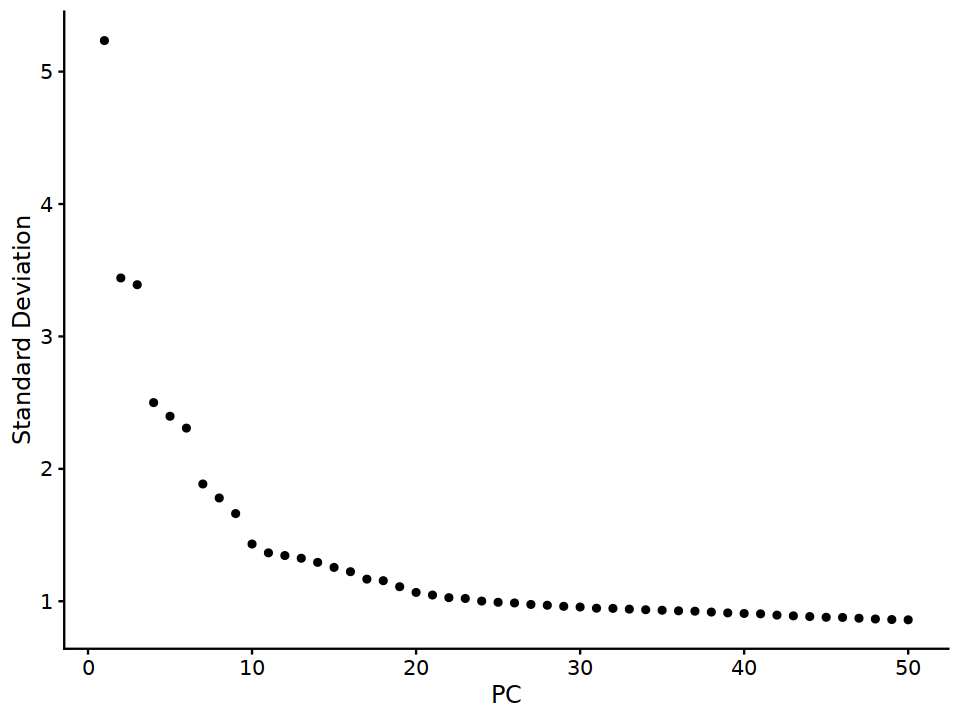

In [27]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [28]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:15,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

09:19:46 UMAP embedding parameters a = 0.9922 b = 1.112

09:19:46 Read 10980 rows and found 15 numeric columns

09:19:46 Using Annoy for neighbor search, n_neighbors = 30

09:19:46 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:19:47 Writing NN index file to temp file /scratch_tmp/33943067/Rtmp1KmEc0/file300955cbaf035

09:19:47 Searching Annoy index using 1 thread, search_k = 3000

09:19:51 Annoy recall = 100%

09:19:52 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

09:19:53 Initializing from normalized Laplacian + noise (using irlba)

09:19:53 Commencing optimization for 200 epochs, with 463198 positive edges

09:20:06 Optimization finished



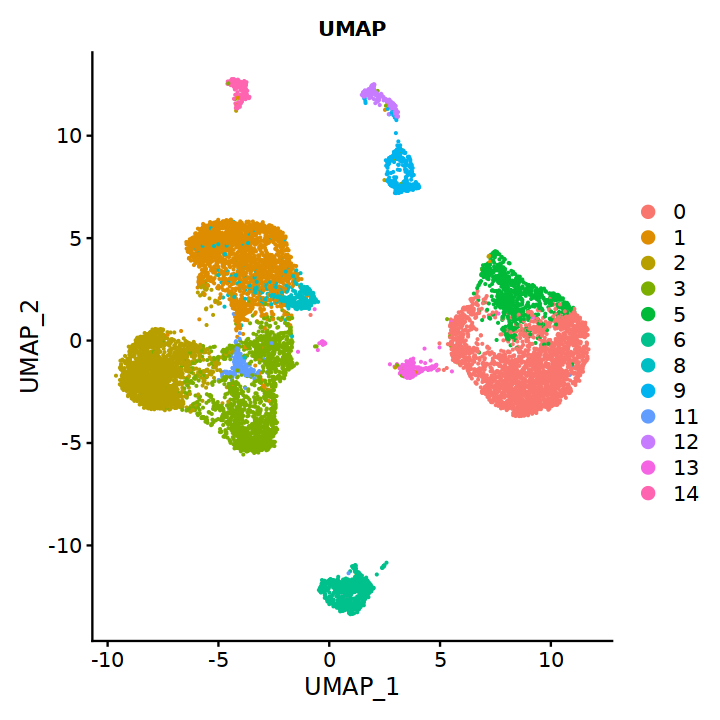

In [29]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  pt.size = 0.1
) + ggtitle(glue('UMAP')) + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

In [30]:
# Find the K-nearest neighbors
seurat_obj <- FindNeighbors(seurat_obj, reduction = "pca", dims = 1:15)
# Find clusters at different resolutions
clusters_df <- cluster_diff_resolutions(
  seurat_obj = seurat_obj,
  min_resolution = 0.1,
  max_resolution = 1.0,
  step = 0.1
)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10980
Number of edges: 392325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9674
Number of communities: 7
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10980
Number of edges: 392325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9475
Number of communities: 9
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10980
Number of edges: 392325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9329
Number of communities: 14
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10980
Number of edges: 392325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9221
Number of communities: 14
Elapsed time: 1 seconds
Modularity Opt

In [31]:
list_plots <- lapply(unique(clusters_df$resolution), function(x) {
  p <- add_reso_results(seurat_obj, clusters_df, resolution=x)
  umap <- DimPlot(p, reduction = "umap", 
                  group.by=glue::glue("seurat_clusters")) +
    labs(title=glue::glue("Resolution {x}"))
  return(umap)
})

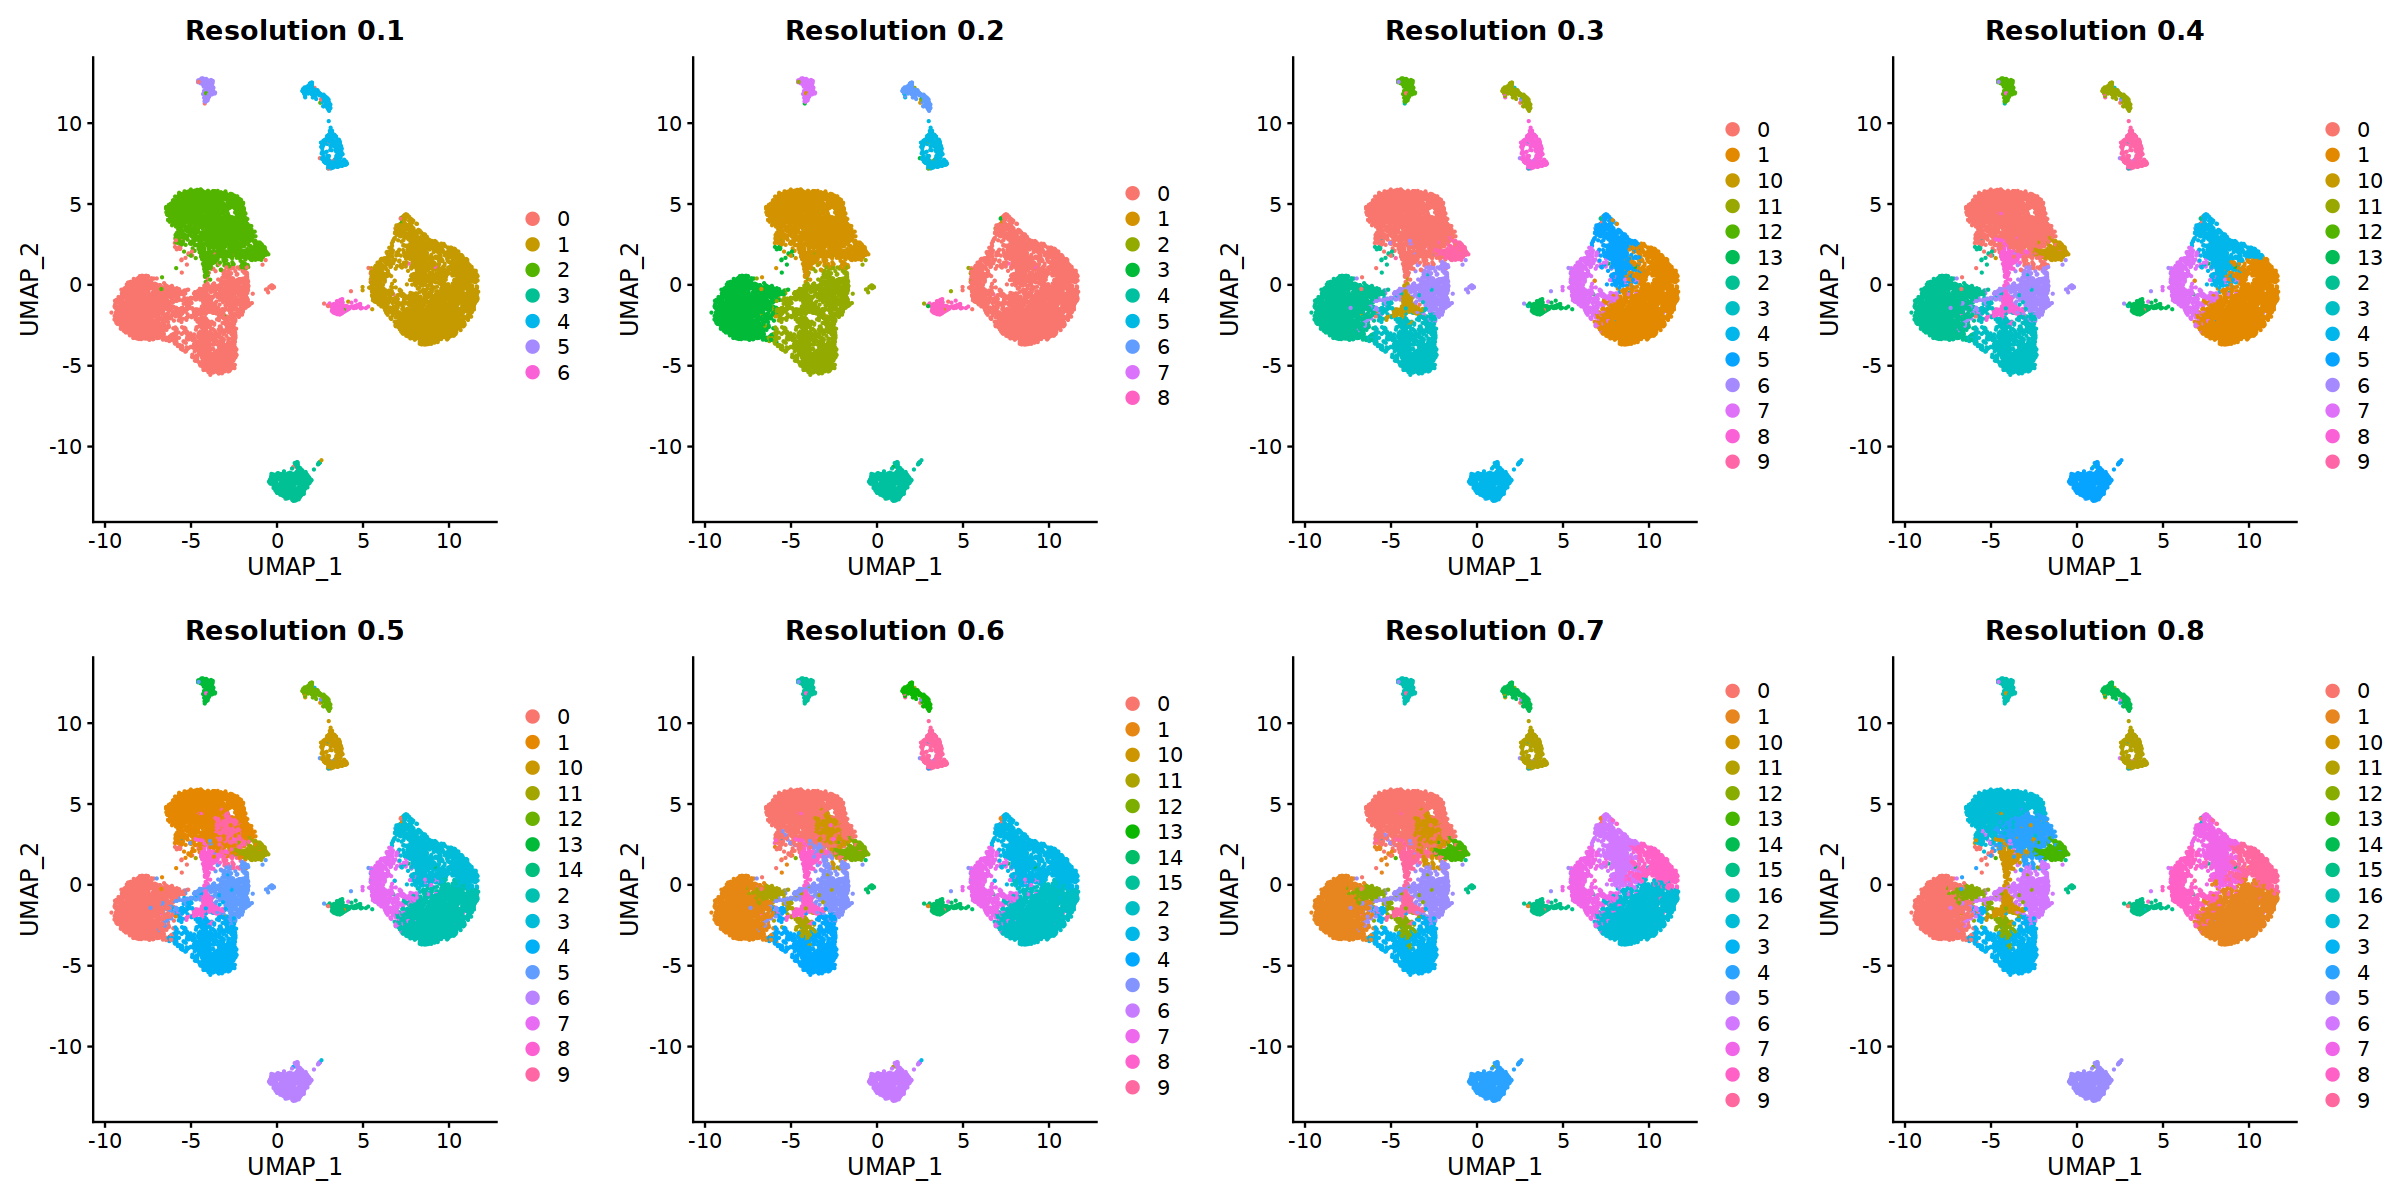

In [32]:
options(repr.plot.width = 20, repr.plot.height = 10, warn=-1,verbose = FALSE)
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol=4,
                   nrow=2)
cp

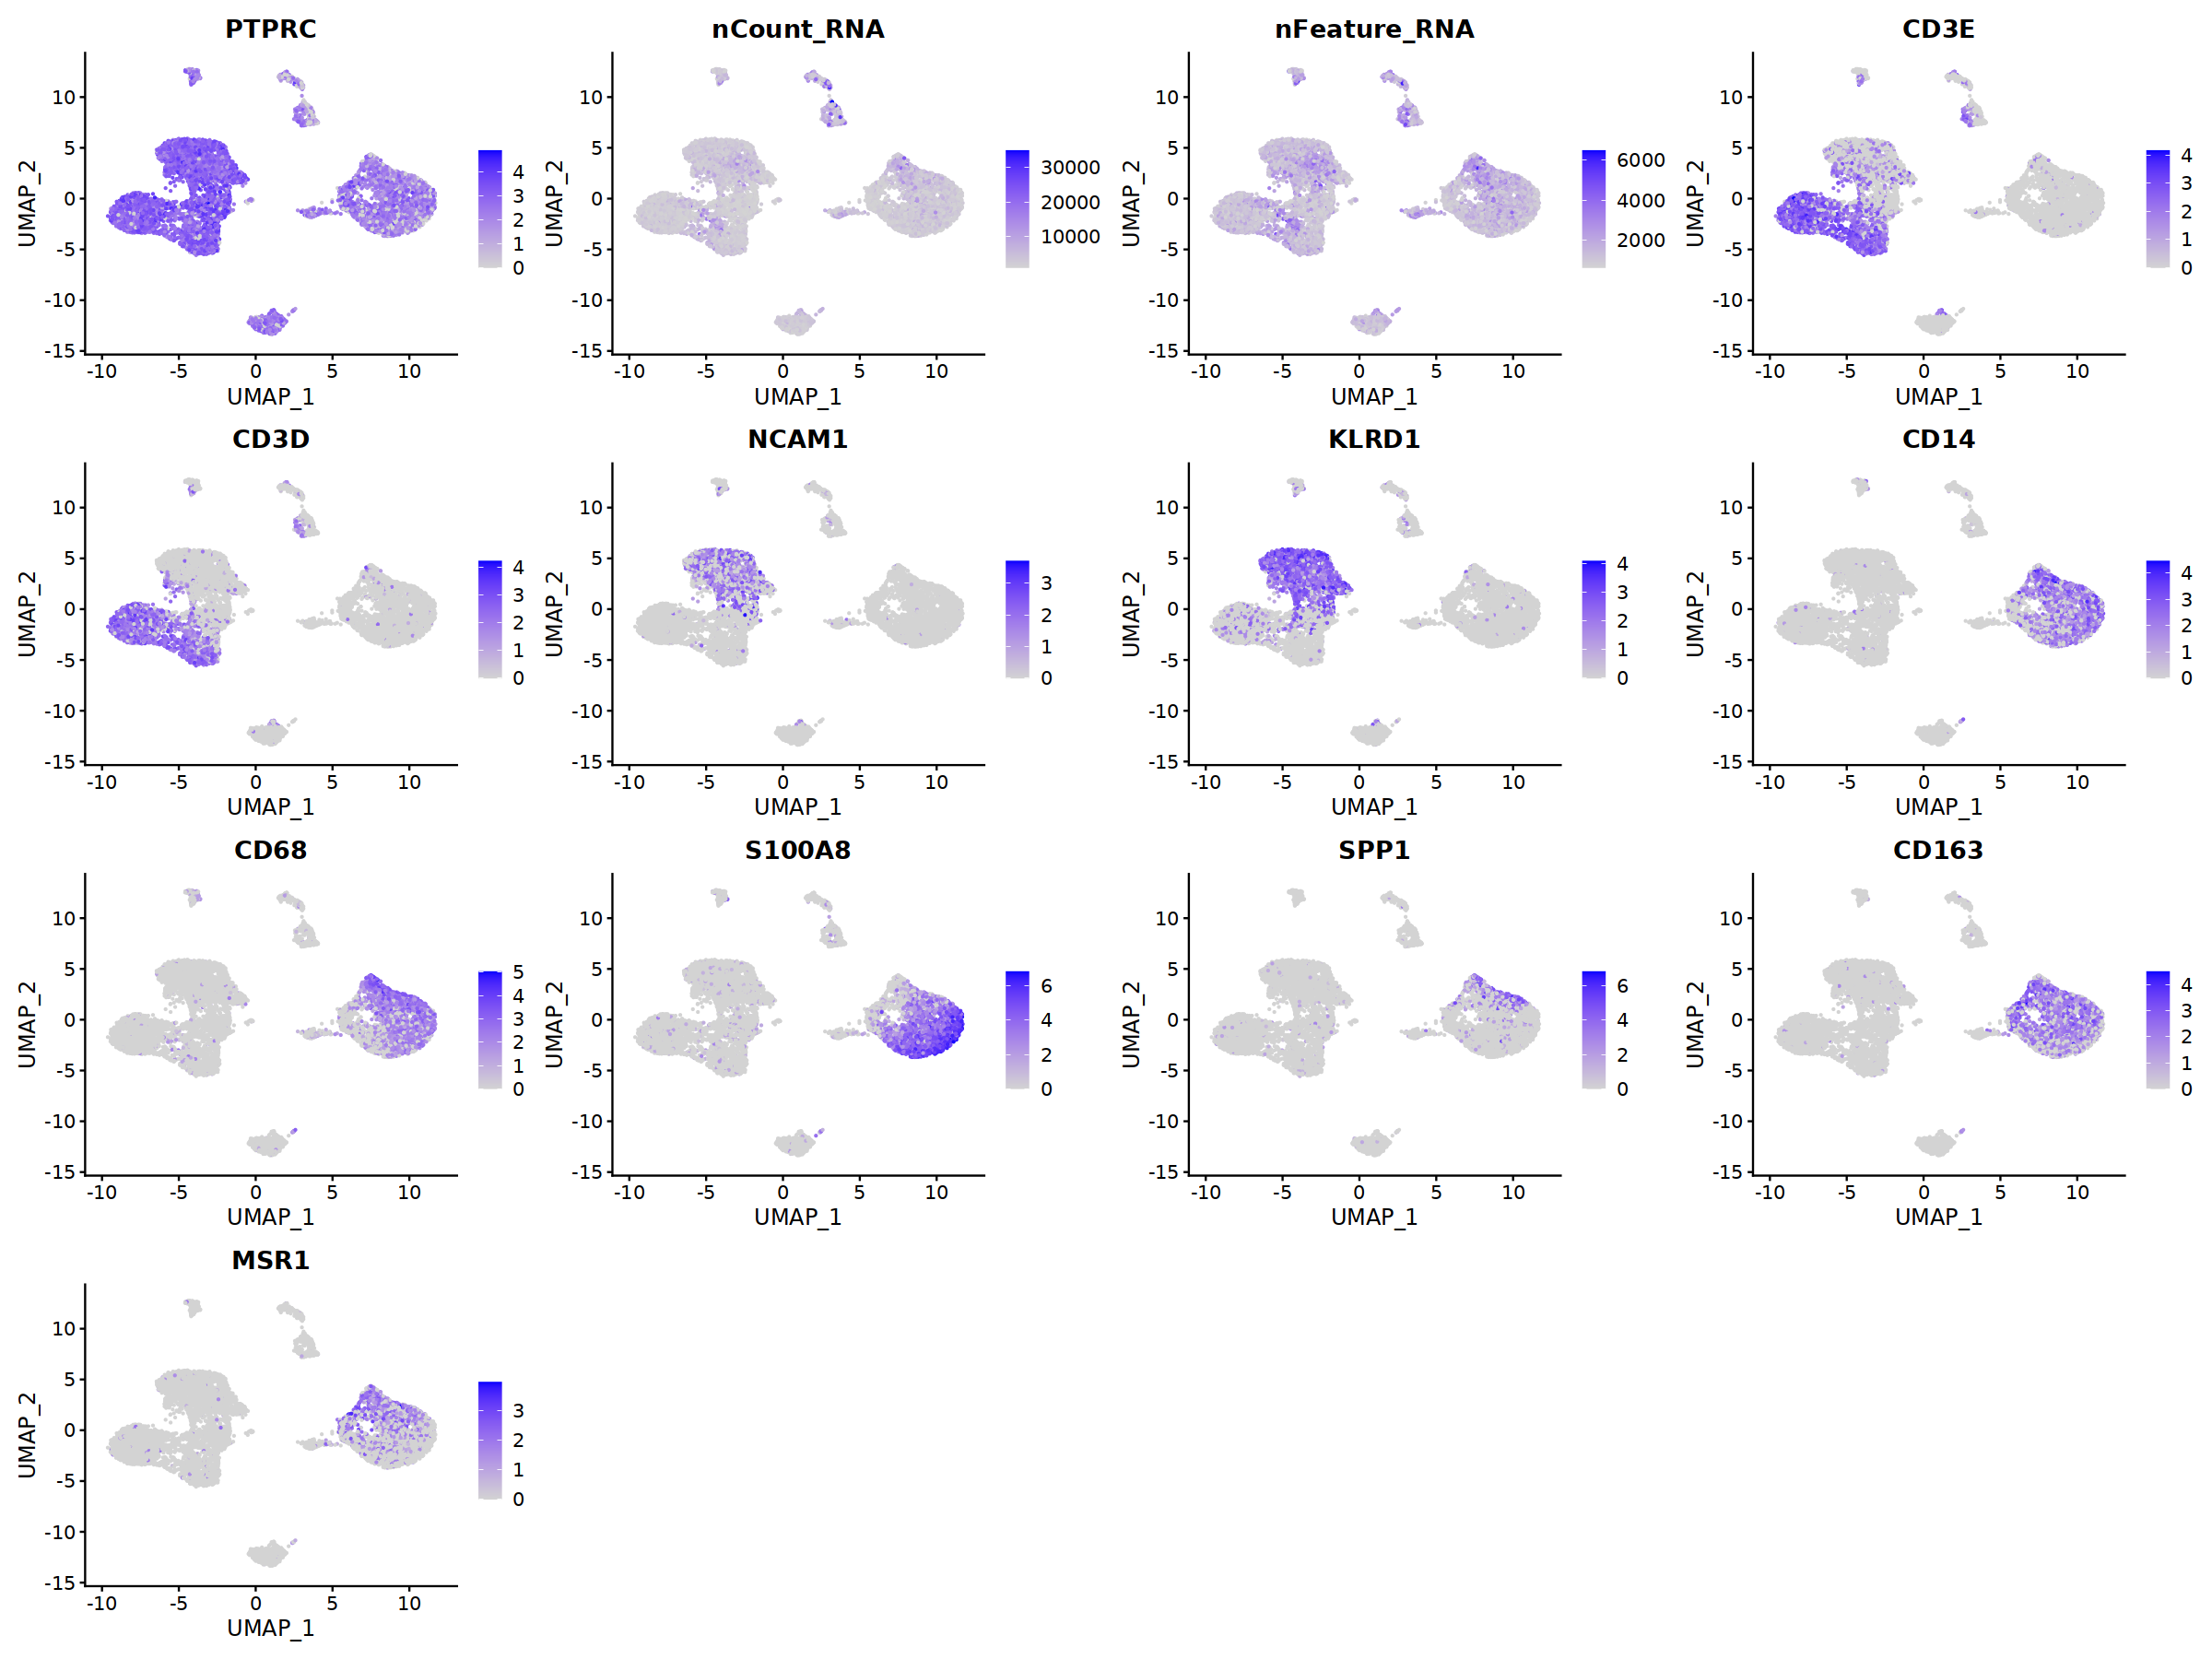

In [33]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
FeaturePlot(seurat_obj, ncol=4,
            feature=c("PTPRC","nCount_RNA", "nFeature_RNA", 
                       "CD3E", "CD3D","NCAM1","KLRD1","CD14", "CD68", 
                       "S100A8", "SPP1", "CD163", "MSR1"))

In [34]:
reso = 0.3

In [35]:
seurat_obj <- FindClusters(seurat_obj, resolution = reso)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10980
Number of edges: 392325

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9329
Number of communities: 14
Elapsed time: 1 seconds


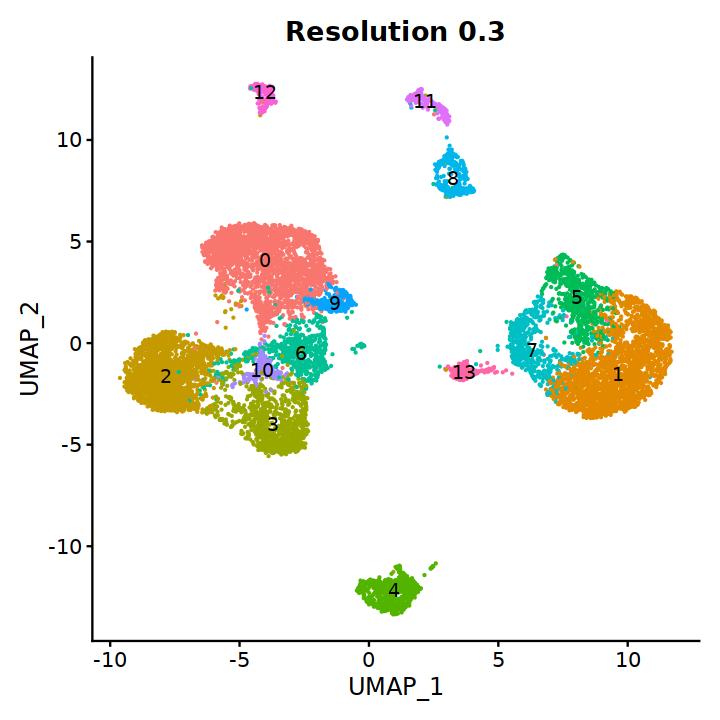

In [36]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(seurat_obj, reduction = "umap", label = T)+ NoLegend() +
  labs(title=glue("Resolution {reso}")) + theme(plot.title = element_text(hjust = 0.5))

In [37]:
rna.markers <- FindAllMarkers(seurat_obj, min.pct = 0.1, 
                              logfc.threshold = 0.1, only.pos = T,
                              random.seed=0, max.cells.per.ident=1000)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13



In [38]:
c <-6

rna.markers %>% 
  dplyr::filter(cluster == c) %>% 
  dplyr::filter(p_val_adj < 0.05) %>% 
  arrange(desc(avg_log2FC)) %>% head(n=20)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    cluster gene     
PRKCH2     8.209300e-102 2.039606   0.847 0.518 2.280790e-97 6       PRKCH    
PIP4K2A1    7.330801e-73 1.916901   0.735 0.475 2.036716e-68 6       PIP4K2A  
NCALD1      3.317140e-42 1.834490   0.507 0.238 9.216009e-38 6       NCALD    
CBLB2      5.356498e-102 1.816906   0.905 0.643 1.488196e-97 6       CBLB     
CNOT6L3     2.028832e-57 1.802200   0.695 0.437 5.636703e-53 6       CNOT6L   
LINC019341  3.198669e-36 1.763900   0.509 0.274 8.886862e-32 6       LINC01934
SFMBT21     1.105578e-53 1.752463   0.635 0.393 3.071628e-49 6       SFMBT2   
ATXN11      3.283351e-58 1.745133   0.737 0.524 9.122133e-54 6       ATXN1    
PDE3B2      1.243900e-49 1.690604   0.661 0.429 3.455927e-45 6       PDE3B    
SKAP13      6.273467e-59 1.686731   0.680 0.401 1.742957e-54 6       SKAP1    
TSPAN52     1.747858e-37 1.676262   0.431 0.182 4.856073e-33 6       TSPAN5   
TOX3        2.521741e-45 1.601269   0.628 0.399 7.006152e-41 6       TOX      
CADM11      3.427527e-08 1.585736   0.210 0.123 9.522699e-04 6       CADM1    
KLF121      2.532478e-38 1.573746   0.485 0.242 7.035984e-34 6       KLF12    
PPP1R16B2   1.029088e-28 1.568190   0.399 0.198 2.859115e-24 6       PPP1R16B 
IKZF22      1.612682e-24 1.559292   0.472 0.283 4.480513e-20 6       IKZF2    
CHST112     2.116135e-67 1.546190   0.805 0.617 5.879257e-63 6       CHST11   
INPP4B2     6.627127e-25 1.538204   0.404 0.218 1.841215e-20 6       INPP4B   
PTPRJ       6.186388e-39 1.532261   0.577 0.371 1.718764e-34 6       PTPRJ    
PAM2        4.012327e-38 1.531520   0.467 0.238 1.114745e-33 6       PAM

In [39]:
some_feat = c("PTPRC","nCount_RNA", "nFeature_RNA",
              "doublet_score",
              "CD3E", "CD3D","NCAM1","KLRD1","FCGR3A",
              "CD14", "CD68", 
              "S100A8", "SPP1", "CD163", "MSR1")

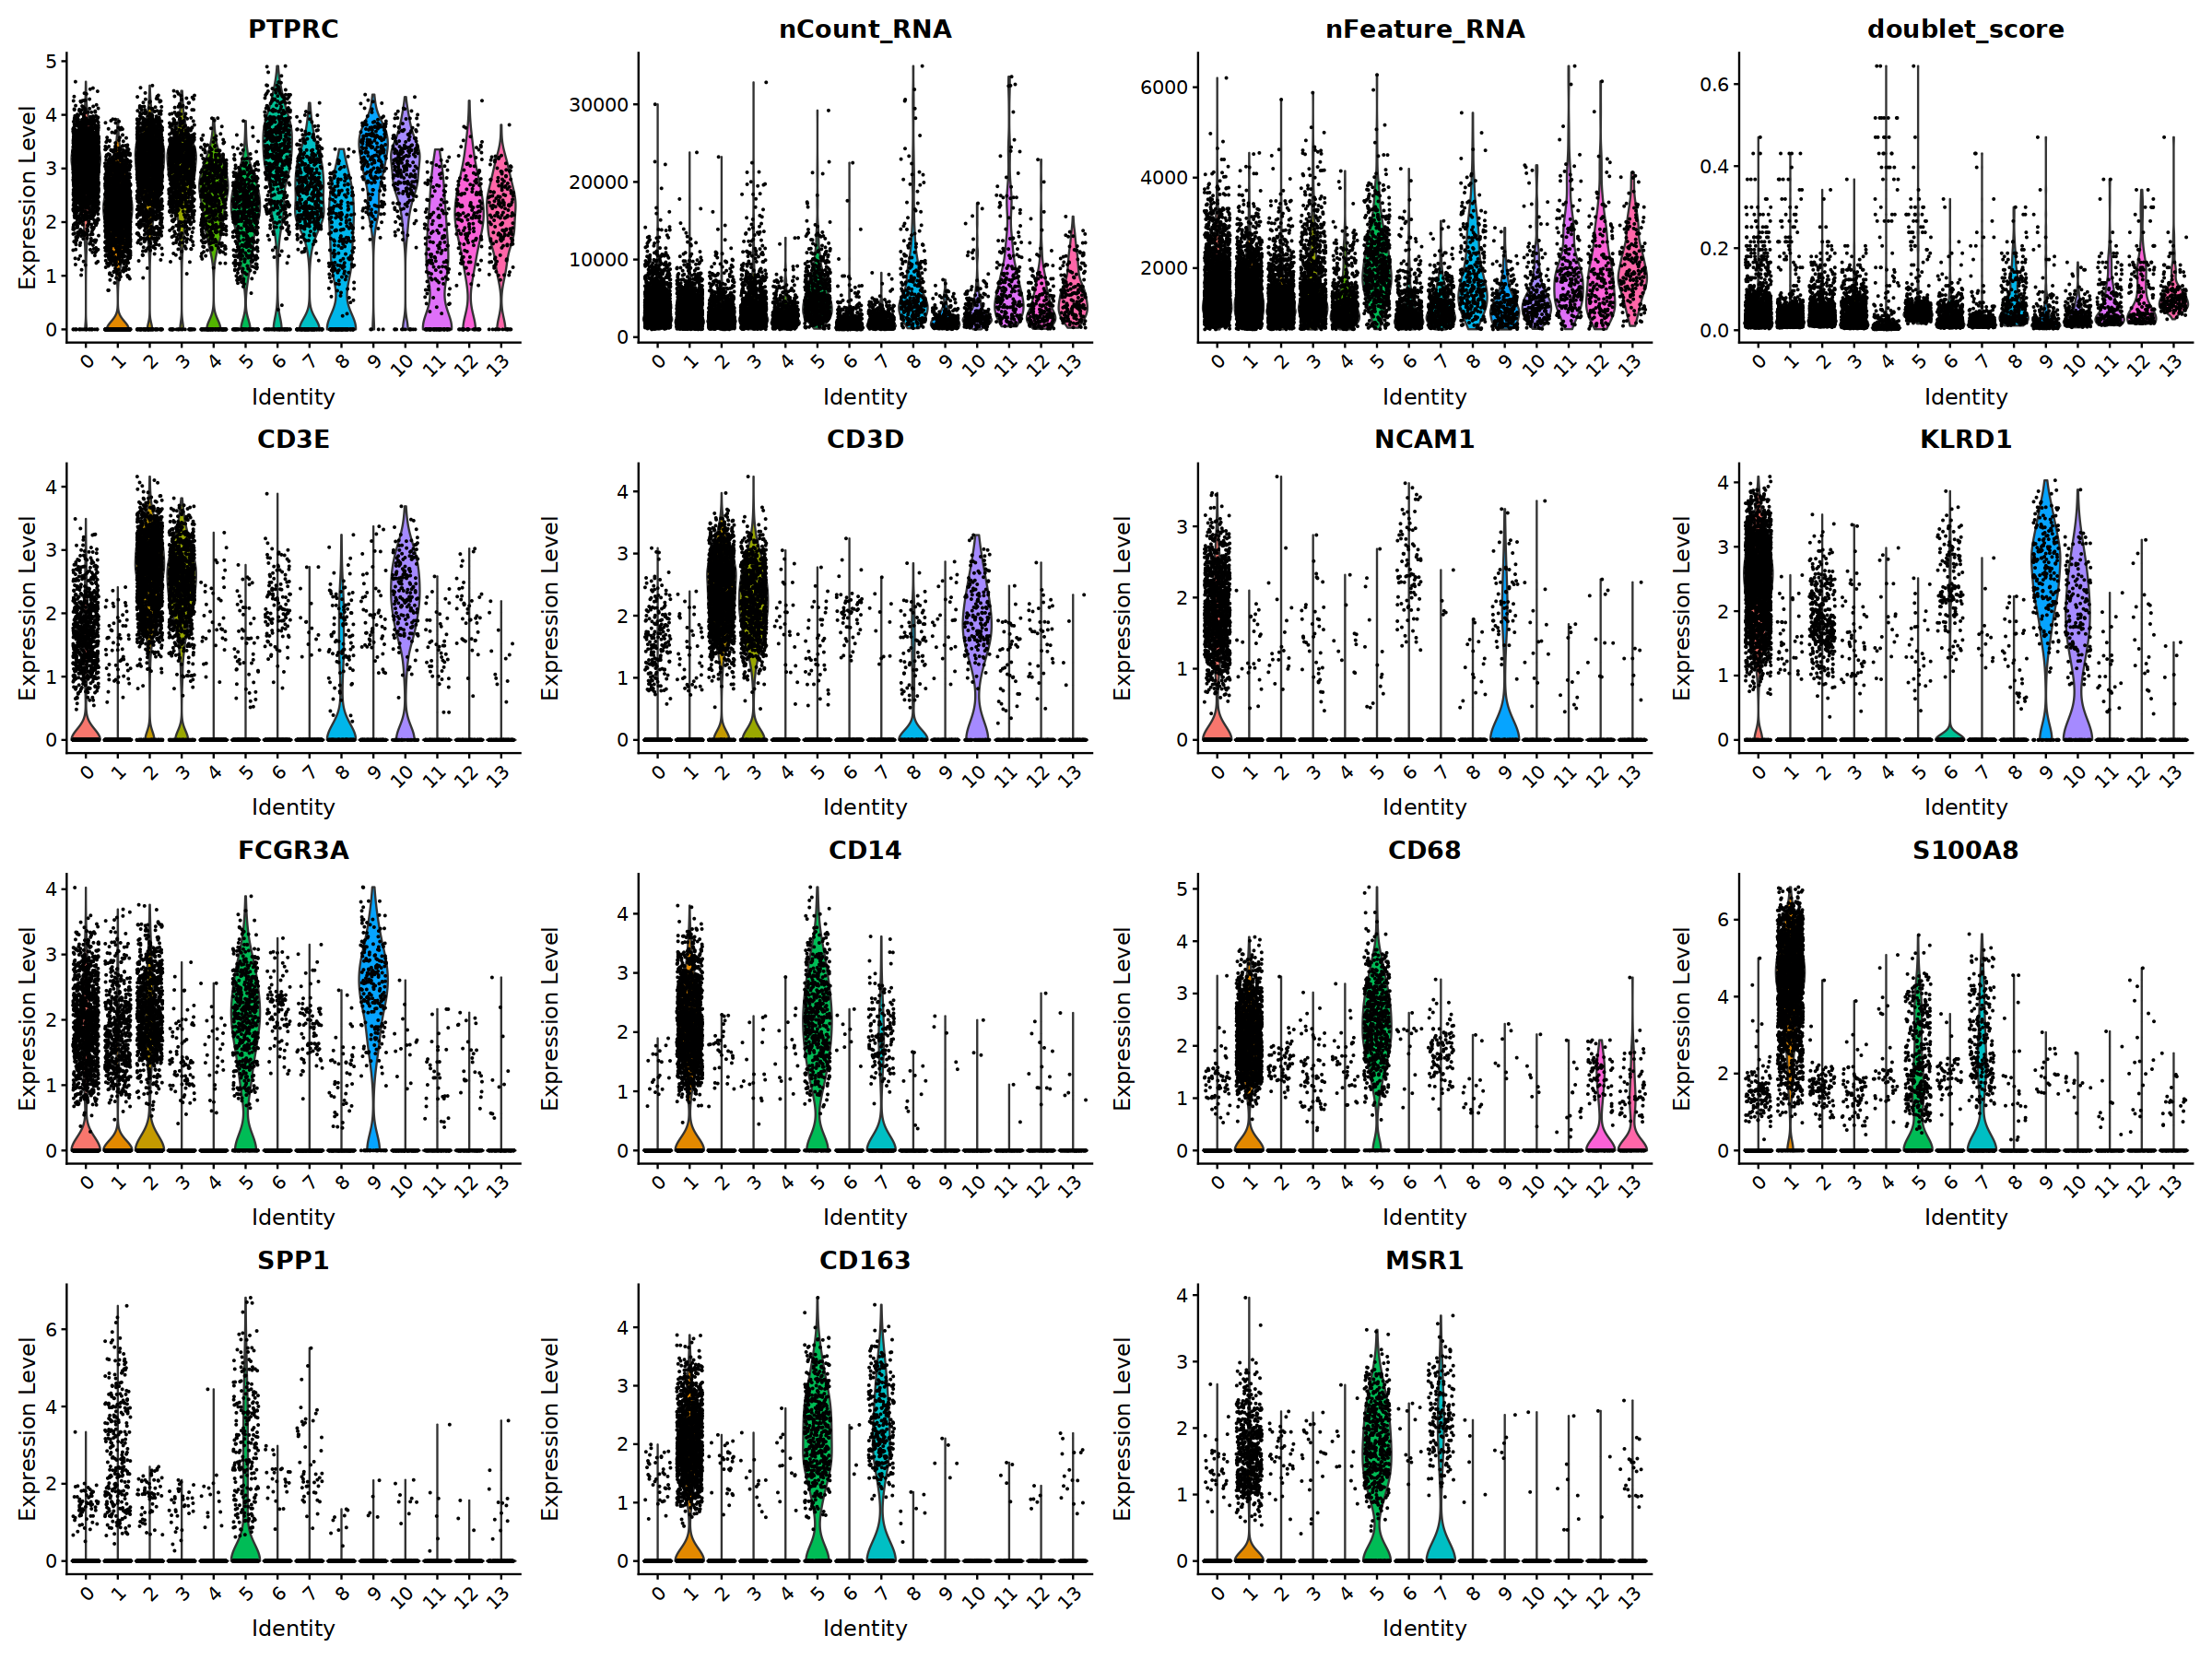

In [40]:
options(repr.plot.width = 20, repr.plot.height = 15, warn=-1,verbose = FALSE)
VlnPlot(seurat_obj, feature=some_feat, ncol=4)

# Save

In [41]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/3.2-clustering_T0_CD45pos.rds")))

In [42]:
write_csv(rna.markers, here(glue("{clust}/{robj_dir}/3.2-clustering_T0_CD45pos.csv")))

# Session Info

In [43]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_